# Objective

In this notebook we will do a rough first attempt at building the cloud classifier. Specifically, we'll build a simple NN that's just a few hidden layers, not even a CNN. This will be the first in a series of notebooks where we build out more and more sophisticated models.

In [1]:
import tensorflow as tf
from tensorflow import keras
import joblib
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

2024-05-16 01:05:41.233697: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
RANDOM_SEED = 0

## Data prep

In [3]:
X, y = joblib.load("CCSN.joblib")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)

To use a simple NN, we're going to have to simplify our data. To do this, we're going to convert the images from BGR to greyscale. Checking with chatgpt, it looks like we can just do np.dot with a very specific array; apparently there's a known vector of weights which can be used to convert a BGR vector to a scalar representing the greyscale value.

First, let's look at a few images to check that this works.

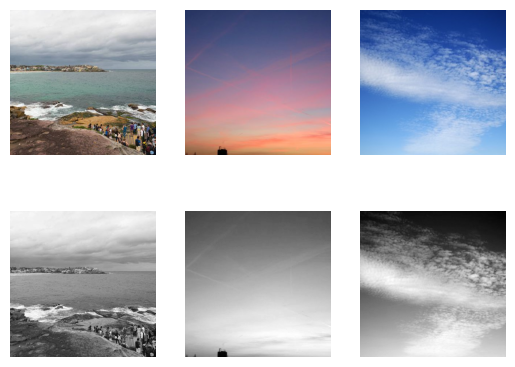

In [4]:
bgr2grey_weights = np.array([0.114, 0.587, 0.299])
grey_images = np.dot(X_train[:3,...], bgr2grey_weights).astype(np.uint8)

fig, axes = plt.subplots(2,3)
for i in range(3):
    img_color = cv2.cvtColor(X_train[i], cv2.COLOR_BGR2RGB)
    img_grey = grey_images[i]
    ax_color = axes[0, i]
    ax_grey = axes[1, i]
    ax_color.imshow(img_color)
    ax_grey.imshow(img_grey, cmap="grey")
    ax_color.axis("off")
    ax_grey.axis("off")

Alright cool, now all we have to do is expand the product to all images in our train and test sets.

(-0.5, 399.5, 399.5, -0.5)

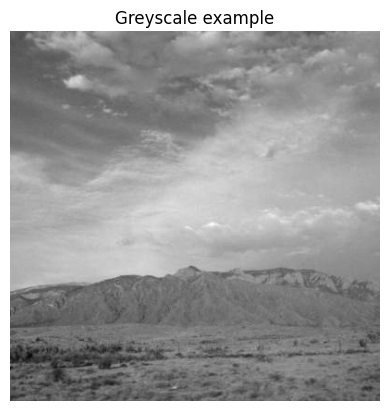

In [5]:
X_train = np.dot(X_train, bgr2grey_weights).astype(np.uint8)
X_test = np.dot(X_test, bgr2grey_weights).astype(np.uint8)

img = X_test[123]
plt.imshow(img, cmap="grey")
plt.title("Greyscale example")
plt.axis("off")

Also before we can use our labels, we need to encode them into integers otherwise keras will yell

In [6]:
from sklearn.preprocessing import LabelEncoder

classes = np.unique(y_train)
classes = np.sort(classes)
num_classes = classes.size
le = LabelEncoder()
le.fit(classes)
y_train = le.transform(y_train)
y_train[:5]

array([8, 6, 3, 2, 9])

In [7]:
le.inverse_transform(y_train[:5])

array(['Ns', 'Ct', 'Cc', 'Cb', 'Sc'], dtype='<U2')

In [8]:
y_test = le.transform(y_test)

## Training

### Baby model

In [9]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(400,400)),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(num_classes)
])

model.summary()

/Users/adu/miniconda3/envs/clouds/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 160000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    10,240,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,240,779 (39.07 MB)

 Trainable params: 10,240,779 (39.07 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

model.fit(X_train, y_train, epochs=5)

Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.1086 - loss: 8674.5723
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.0847 - loss: 2.8275
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.1375 - loss: 2.3956
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - accuracy: 0.1440 - loss: 2.3927
Epoch 5/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.1242 - loss: 2.3912


Let's evaluate this

In [11]:
probability_model = keras.models.Sequential([
    model,
    keras.layers.Softmax()
])

def prediction_summary(model, sample, label_name):
    plt.imshow(sample, cmap="grey")
    plt.axis("off")
    plt.show()

    img_height, img_width = sample.shape
    sample = sample.reshape(1, img_height, img_width)
    probabilities = model.predict(sample)

    predicted = np.argmax(probabilities)
    predicted_label_name = le.inverse_transform(predicted.reshape(1,))
    predicted_proba = np.max(probabilities) * 100

    print(f"Predicted {predicted_label_name} with probabilitiy {predicted_proba:.1f}%")
    print(f"The true label is {label_name}")

    if predicted_label_name == label_name:
        return 1
    else:
        return 0

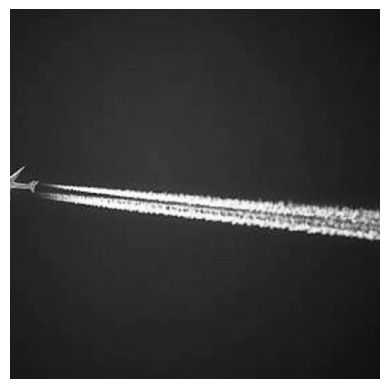

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Predicted ['Sc'] with probabilitiy 9.9%
The true label is ['Ct']


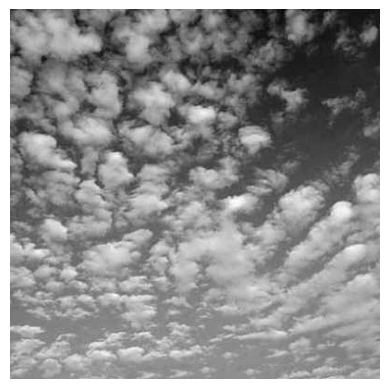

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted ['Sc'] with probabilitiy 9.9%
The true label is ['Cs']


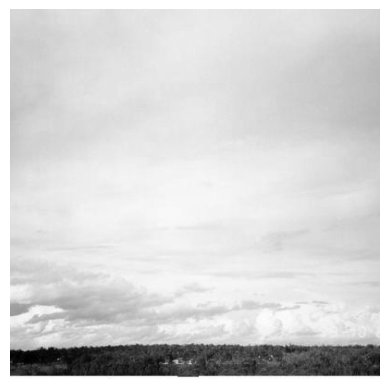

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted ['Sc'] with probabilitiy 9.9%
The true label is ['Cs']


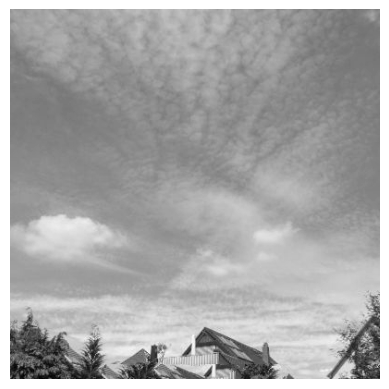

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted ['Sc'] with probabilitiy 9.9%
The true label is ['Cc']


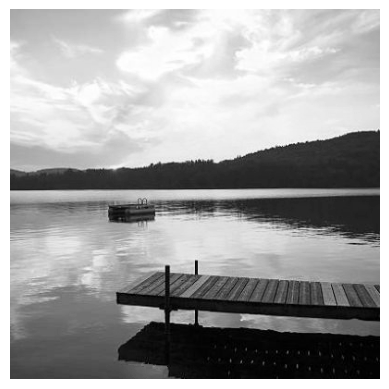

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted ['Sc'] with probabilitiy 9.9%
The true label is ['Cs']


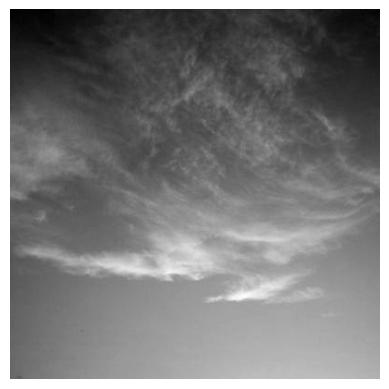

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted ['Sc'] with probabilitiy 9.9%
The true label is ['Cc']


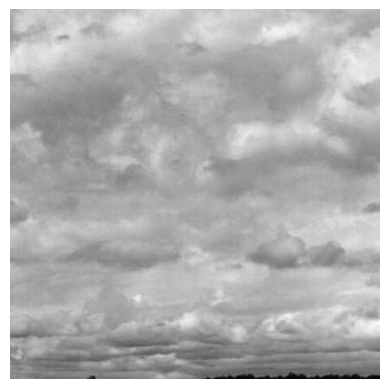

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted ['Sc'] with probabilitiy 9.9%
The true label is ['Sc']


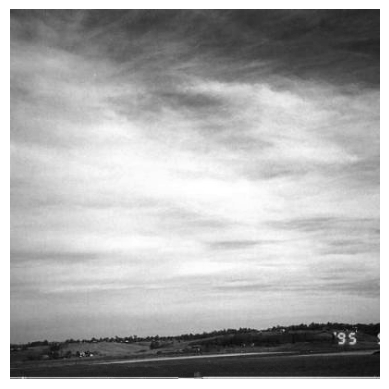

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted ['Sc'] with probabilitiy 9.9%
The true label is ['Cs']


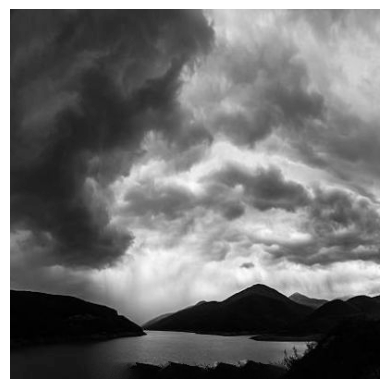

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted ['Sc'] with probabilitiy 9.9%
The true label is ['Ns']


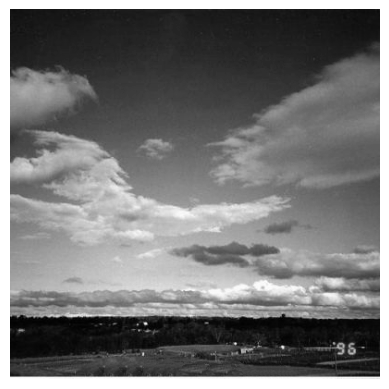

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted ['Sc'] with probabilitiy 9.9%
The true label is ['Sc']

Got 2 predictions correct out of 10


In [12]:
N_test = y_test.size
num_samples = 10
random_sample = np.random.randint(1, N_test, num_samples)
num_correct = 0

for idx in random_sample:
    sample = X_test[idx]
    label = y_test[idx]
    label = label.reshape(1,)
    label_name = le.inverse_transform(label)
    num_correct += prediction_summary(probability_model, sample, label_name)

print()
print(f"Got {num_correct} predictions correct out of {num_samples}")

In [13]:
train_accuracy = model.evaluate(X_train, y_train, verbose=2)[1]*100
test_accuracy = model.evaluate(X_test, y_test, verbose=2)[1]*100

print(f"The train set got an accuracy of {train_accuracy:.1f}% and the test set got {test_accuracy:.1f}%")

64/64 - 1s - 16ms/step - accuracy: 0.1372 - loss: 2.3883
16/16 - 0s - 12ms/step - accuracy: 0.1198 - loss: 2.4066
The train set got an accuracy of 13.7% and the test set got 12.0%


This model sucks. Make it bigger maybe?

### Toddler model

In [14]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(400,400)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(num_classes)
])

model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

model.fit(X_train, y_train, epochs=10)

/Users/adu/miniconda3/envs/clouds/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 213ms/step - accuracy: 0.1118 - loss: 11186.1631
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 212ms/step - accuracy: 0.1283 - loss: 1631.3546
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step - accuracy: 0.1238 - loss: 942.4125
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step - accuracy: 0.1447 - loss: 786.8276
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - accuracy: 0.1370 - loss: 520.8973
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 181ms/step - accuracy: 0.0907 - loss: 79.9494
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - accuracy: 0.0951 - loss: 2.3988
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 185ms/step - accuracy: 0.1095 - loss: 2.3919
Epoch 9/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step - accuracy: 0.1089 - loss: 2.3898
Epoch 10/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - accuracy: 0.1068 - loss: 2.3864


In [15]:
probability_model = keras.models.Sequential([
    model,
    keras.layers.Softmax()
])

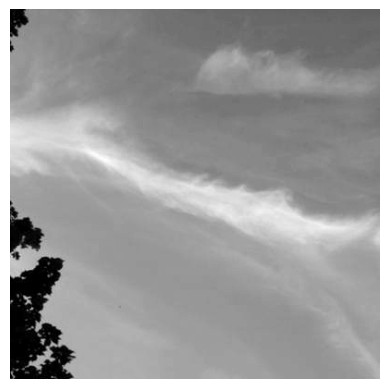

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted ['Ns'] with probabilitiy 10.1%
The true label is ['Ci']


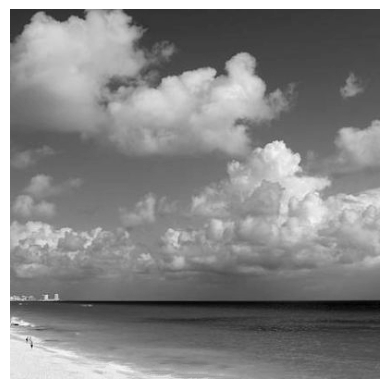

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted ['Ns'] with probabilitiy 10.1%
The true label is ['Cc']


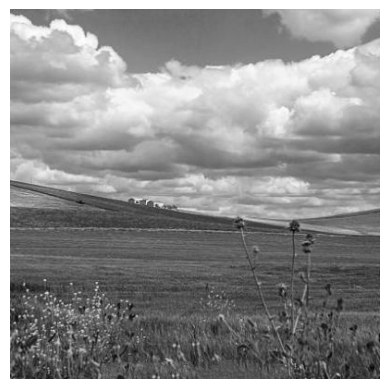

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted ['Ns'] with probabilitiy 10.1%
The true label is ['Ns']


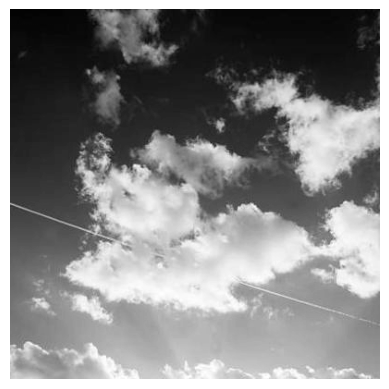

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted ['Ns'] with probabilitiy 10.1%
The true label is ['Ct']


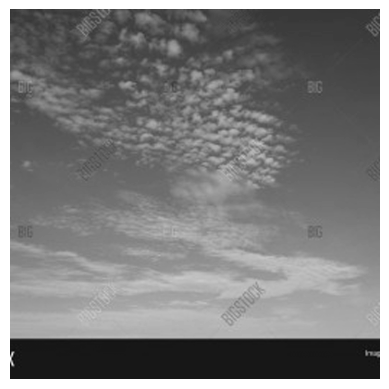

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted ['Ns'] with probabilitiy 10.1%
The true label is ['Cc']


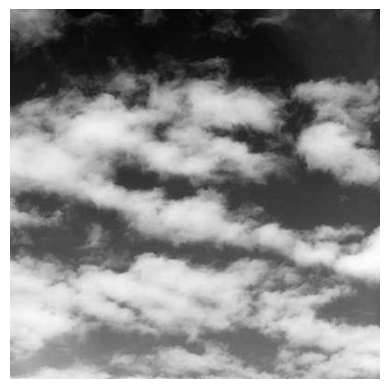

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted ['Ns'] with probabilitiy 10.1%
The true label is ['Ac']


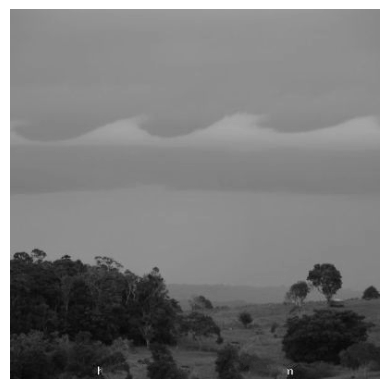

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted ['Ns'] with probabilitiy 10.1%
The true label is ['Ns']


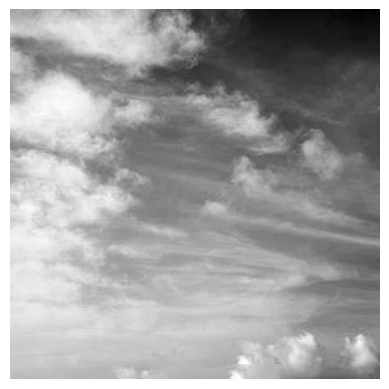

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted ['Ns'] with probabilitiy 10.1%
The true label is ['Cs']


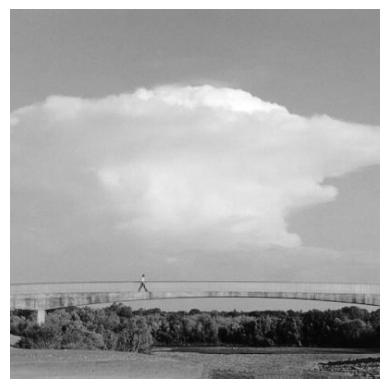

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted ['Ns'] with probabilitiy 10.1%
The true label is ['Cb']


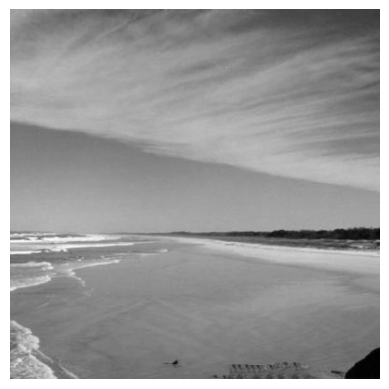

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted ['Ns'] with probabilitiy 10.1%
The true label is ['Ci']

Got 2 predictions correct out of 10


In [16]:
N_test = y_test.size
num_samples = 10
random_sample = np.random.randint(1, N_test, num_samples)
num_correct = 0

for idx in random_sample:
    sample = X_test[idx]
    label = y_test[idx]
    label = label.reshape(1,)
    label_name = le.inverse_transform(label)
    num_correct += prediction_summary(probability_model, sample, label_name)

print()
print(f"Got {num_correct} predictions correct out of {num_samples}")

In [17]:
train_accuracy = model.evaluate(X_train, y_train, verbose=2)[1]*100
test_accuracy = model.evaluate(X_test, y_test, verbose=2)[1]*100

print(f"The train set got an accuracy of {train_accuracy:.1f}% and the test set got {test_accuracy:.1f}%")

64/64 - 1s - 21ms/step - accuracy: 0.1052 - loss: 2.3861
16/16 - 0s - 22ms/step - accuracy: 0.1179 - loss: 2.3845
The train set got an accuracy of 10.5% and the test set got 11.8%


It got worse! Are we at least doing better than random guessing?

### Dummy model

In [18]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="stratified", random_state=0)
dummy.fit(X_train, y_train)
train_accuracy = dummy.score(X_train, y_train)*100
test_accuracy = dummy.score(X_test, y_test)*100

print(f"The dummy model got an accuracy of {train_accuracy:.1f}% on the train set and {test_accuracy:.1f}% on the test set")

The dummy model got an accuracy of 9.4% on the train set and 7.7% on the test set


Ok so at least it's not worse than the dummy model. The NN learned some kind of pattern.

## Conclusion

In this notebook we did some basic data preprocessing so we understand how to plug in our data into a keras model. We saw that a small basic model can outperform chance pretty easily. The next step is to refine both procedures: the data processing and the modeling strategy. Next time we'll iterate on this by:

- Creating more data (synthetic data)
- Using a larger model with regularization